In [1]:
%pip install -Uq "unstructured[all-docs]" pillow lxml 
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community 
!pip install gpt4all
!pip install -U langchain-chroma
%pip install -Uq langchain-groq

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-chroma 0.1.4 requires chromadb!=0.5.4,!=0.5.5,<0.6.0,>=0.4.0, but you have chromadb 0.6.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached chromadb-0.5.23-py3-none-any.whl.metadata (6.8 kB)
Using cached chromadb-0.5.23-py3-none-any.whl (628 kB)
  Attempting uninstall: chromadb
    Found existing installation: chromadb 0.6.1
    Uninstalling chromadb-0.6.1:
      Successfully uninstalled chromadb-0.6.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
)

/home/ubuntu/newenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
set([str(type(chunk)) for chunk in chunks])


{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [5]:
chunks[3].metadata.orig_elements


In [6]:
elements=chunks[3].metadata.orig_elements
chunk_images=[el for el in elements if "Image" in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'bb68f5d0-146c-499b-8eed-2d6c19248856',
 'text': 'Scaled Dot-Product Attention  Multi-Head Attention ',
 'metadata': {'detection_class_prob': 0.8599751591682434,
  'coordinates': {'points': ((410.50833333333327, 197.0675599999999),
    (410.50833333333327, 669.3112182617188),
    (1311.755126953125, 669.3112182617188),
    (1311.755126953125, 197.0675599999999)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-01-06T14:51:36',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpT

In [7]:
tables=[]
texts=[]
for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)
    if "CompositeElement" in str(type(chunk)):
        texts.append(chunk)

In [8]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

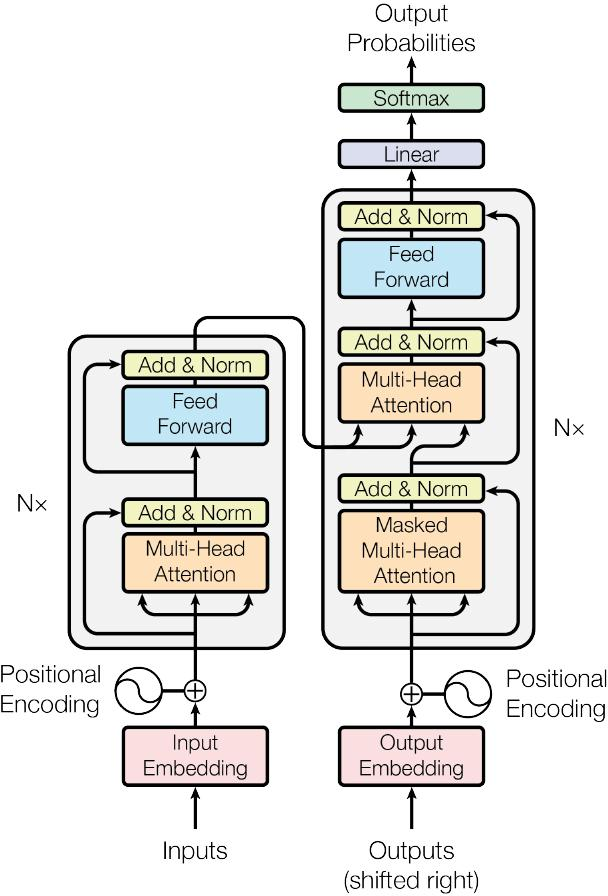

In [9]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [10]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [11]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [12]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [13]:
text_summaries

['The paper "Attention Is All You Need" proposes the Transformer model, a simple neural network architecture based on attention mechanisms, which achieves state-of-the-art results in machine translation tasks, including a 28.4 BLEU score on the WMT 2014 English-to-German task and a 41.8 BLEU score on the WMT 2014 English-to-French task.',
 'Recurrent neural networks have been established as state-of-the-art approaches in sequence modeling and transduction problems. However, they have limitations in parallelization and memory constraints. Recent work has achieved improvements in computational efficiency through factorization tricks and conditional computation, but the fundamental constraint of sequential computation remains. Attention mechanisms have become integral to sequence modeling and transduction models, but are often used in conjunction with recurrent networks.',
 'The Transformer model has an encoder-decoder architecture with stacked self-attention and fully connected layers. T

In [14]:
prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)
model = ChatGroq(temperature=0.5, model="llama-3.2-11b-vision-preview")

chain = prompt | model | StrOutputParser()


image_summaries = chain.batch(images)

In [15]:
image_summaries

['The image presents a comprehensive diagram of the Transformers architecture, a neural network model designed for natural language processing tasks. The diagram illustrates the various components and their interactions within the architecture.\n\n**Components of the Transformers Architecture**\n\n*   **Input Embeddings**: The input embeddings are responsible for converting the input text into numerical representations that can be processed by the neural network.\n*   **Positional Encodings**: The positional encodings are used to capture the order of the input tokens and provide additional information to the model.\n*   **Self-Attention Mechanism**: The self-attention mechanism allows the model to attend to different parts of the input sequence simultaneously and weigh their importance.\n*   **Feed Forward Network**: The feed forward network is a fully connected neural network that transforms the output of the self-attention mechanism.\n*   **Layer Normalization**: The layer normalizat

In [16]:
print(image_summaries[0])

The image presents a comprehensive diagram of the Transformers architecture, a neural network model designed for natural language processing tasks. The diagram illustrates the various components and their interactions within the architecture.

**Components of the Transformers Architecture**

*   **Input Embeddings**: The input embeddings are responsible for converting the input text into numerical representations that can be processed by the neural network.
*   **Positional Encodings**: The positional encodings are used to capture the order of the input tokens and provide additional information to the model.
*   **Self-Attention Mechanism**: The self-attention mechanism allows the model to attend to different parts of the input sequence simultaneously and weigh their importance.
*   **Feed Forward Network**: The feed forward network is a fully connected neural network that transforms the output of the self-attention mechanism.
*   **Layer Normalization**: The layer normalization is use

In [27]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import GPT4AllEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=GPT4AllEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [28]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))


# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [19]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [29]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

2023

3

2

0

2 g u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0 7 1

:

arXiv:

v

i

X

r

a

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

Noam Shazeer∗

Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗

Google Research usz@google.com

Llion Jones∗

Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡

illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Tra

In [30]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatGroq(model="llama-3.1-8b-instant")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatGroq(model="llama-3.1-8b-instant")
        | StrOutputParser()
    )
)

In [37]:
response = chain.invoke("What is the attention mechanism?")
print(response)


The attention mechanism is described as a function that maps a query and a set of key-value pairs to an output. It is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.


In [38]:
response = chain_with_sources.invoke(
    "What is the attention mechanism?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The attention mechanism can be described as a mapping of a query and a set of key-value pairs to an output. It is a weighted sum of the values, where the weights are computed by a compatibility function of the query with the corresponding key. This compatibility function is typically a dot product of the query and key, scaled by a factor, and then a softmax function is applied to obtain the weights.


Context:
3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum

3

Scaled Dot-Product Attention Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

3.2.1 Scaled Dot-Product 